# Parâmetros do experimento

In [1]:
DATA_PATH = 'data/motionsense.csv'
LOG_PATH = 'evaluation/gnn_minirocket/'

In [2]:
FEATURES = ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']
SEED = 2024
K = 10
K_NEIGHBORS = 5
EPOCHS = 300

In [3]:
# pontos sao problematicos
FEATURES = [feat.replace('.', '_') for feat in FEATURES]

# Carregando os dados processados

In [4]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv(DATA_PATH, index_col=0)

In [6]:
df.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,id,trial
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,0.0,0.0,1.0
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,0.0,0.0,1.0
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,0.0,0.0,1.0
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,0.0,0.0,1.0
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,0.0,0.0,1.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1412865 entries, 0 to 1412864
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   attitude.roll       1412865 non-null  float64
 1   attitude.pitch      1412865 non-null  float64
 2   attitude.yaw        1412865 non-null  float64
 3   gravity.x           1412865 non-null  float64
 4   gravity.y           1412865 non-null  float64
 5   gravity.z           1412865 non-null  float64
 6   rotationRate.x      1412865 non-null  float64
 7   rotationRate.y      1412865 non-null  float64
 8   rotationRate.z      1412865 non-null  float64
 9   userAcceleration.x  1412865 non-null  float64
 10  userAcceleration.y  1412865 non-null  float64
 11  userAcceleration.z  1412865 non-null  float64
 12  act                 1412865 non-null  float64
 13  id                  1412865 non-null  float64
 14  trial               1412865 non-null  float64
dtypes: float64(15)
memor

In [8]:
df['act'].nunique() # lembrar de mapear id para string da classe

6

# Separando pares X e y

In [9]:
df['act'].unique()

array([0., 1., 2., 3., 4., 5.])

In [10]:
subject_id = 1
act_id = 0
subject_mask = df['id'] == subject_id
act_mask = df['act'] == act_id

X = []
y = []

for label in df['act'].unique():
  for subj_id in df['id'].unique():
    subj_mask = df['id'] == subj_id
    act_mask = df['act'] == label
    filtered_df = df[subj_mask & act_mask].reset_index()

    X.append(
        np.stack(
            [
              filtered_df['userAcceleration.x'].values,
              filtered_df['userAcceleration.y'].values,
              filtered_df['userAcceleration.z'].values
            ]
        )
    )
    y.append(label)

In [11]:
y = np.array(y)

In [12]:
n_labels = np.unique(y).shape[0]
n_labels

6

# Extraindo features usando o MiniRocket

Inpirado no [tutorial](https://www.aeon-toolkit.org/en/stable/examples/transformations/minirocket.html#MiniRocket). Rocket requer que as séries tenham o mesmo tamanho (comprimento). Então, fazemos [padding](https://www.aeon-toolkit.org/en/stable/api_reference/auto_generated/aeon.transformations.collection.pad.PaddingTransformer.html) com zeros.



In [13]:
from aeon.transformations.collection.convolution_based import MiniRocket, Rocket
from aeon.transformations.collection import PaddingTransformer

/home/kenzosaki/miniconda3/envs/ts/lib/python3.10/site-packages/aeon/base/__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(
/home/kenzosaki/miniconda3/envs/ts/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [14]:
univar_X_processed = []
for channel in range(len(FEATURES)):
  print(f'- Processing channel {channel}: {FEATURES[channel]}.')
  X_curr = [np.expand_dims(example[channel], axis=0) for example in X]
  transformer = PaddingTransformer() # é necessário que todas as séries tenham o mesmo tamanho
  minirocket = MiniRocket(num_kernels=10_000, n_jobs=5, random_state=SEED)  # por padrao, MiniRocket usa ~10_000 kernels
  X_padded = transformer.fit_transform(X_curr)
  X_features = minirocket.fit_transform(X_padded)
  univar_X_processed.append(X_features)

- Processing channel 0: userAcceleration_x.
- Processing channel 1: userAcceleration_y.
- Processing channel 2: userAcceleration_z.


# Criando grafos

In [15]:
from sklearn.neighbors import kneighbors_graph
import numpy as np

In [16]:
adj_lists = [kneighbors_graph(univar_X_processed[channel], n_neighbors=K_NEIGHBORS, n_jobs=-1, include_self=False) for channel in range(len(FEATURES))]
print(f'- Using k={K_NEIGHBORS}')

- Using k=5


# Integrando com networkX e PyG 

[Referencia](https://pytorch-geometric.readthedocs.io/en/2.5.1/notes/heterogeneous.html).

In [17]:
import networkx as nx
import numpy as np
from torch_geometric.data import Data, HeteroData
from torch_geometric.utils import from_networkx
from torch_geometric.seed import seed_everything
import torch

In [18]:
def create_data_from_adj_list(adj_list: np.array, features: np.array) -> Data:

    data = HeteroData()

    # adicionando features
    for i, feat in enumerate(FEATURES):
        data[feat].x = torch.Tensor((features[i])).float()

    # adicionando arestas de cada grafo
    for label, adj_list in zip(FEATURES, adj_lists):

        adj_list = adj_list.toarray()
        sources = []
        targets = []

        for i in range(adj_list.shape[0]):
            neighbors = np.where(adj_list[i].astype(int) == 1)[0]
            sources.extend([i] * len(neighbors))
            targets.extend(neighbors.tolist())

        # revertendo arestas
        s_copy = sources.copy()
        t_copy = targets.copy()

        sources.extend(t_copy)
        targets.extend(s_copy)

        edges = torch.LongTensor([sources, targets])
        data[label, f"{label}_neighbor", label].edge_index = edges
    

    # https://github.com/pyg-team/pytorch_geometric/issues/3604
    # conectando arestas de todos os tipos
    # a feature do tipo X do no BLAU tem que estar conectada com a feature do tipo Y do mesmo nó BLAU
    sources = [i for i in range(len(features[0]))]
    targets = sources.copy()

    edges = torch.LongTensor([sources, targets])

    # conectando todas as features do mesmo nó
    for feat_source in FEATURES:
        for feat_dest in FEATURES:
            # nao adicionar self-loop
            if feat_source == feat_dest: continue
            data[feat_source, "is_the_same", feat_dest].edge_index = edges

    return data



In [19]:
data = create_data_from_adj_list(adj_lists, univar_X_processed)

In [20]:
data

HeteroData(
  userAcceleration_x={ x=[144, 9996] },
  userAcceleration_y={ x=[144, 9996] },
  userAcceleration_z={ x=[144, 9996] },
  (userAcceleration_x, userAcceleration_x_neighbor, userAcceleration_x)={ edge_index=[2, 1440] },
  (userAcceleration_y, userAcceleration_y_neighbor, userAcceleration_y)={ edge_index=[2, 1440] },
  (userAcceleration_z, userAcceleration_z_neighbor, userAcceleration_z)={ edge_index=[2, 1440] },
  (userAcceleration_x, is_the_same, userAcceleration_y)={ edge_index=[2, 144] },
  (userAcceleration_x, is_the_same, userAcceleration_z)={ edge_index=[2, 144] },
  (userAcceleration_y, is_the_same, userAcceleration_x)={ edge_index=[2, 144] },
  (userAcceleration_y, is_the_same, userAcceleration_z)={ edge_index=[2, 144] },
  (userAcceleration_z, is_the_same, userAcceleration_x)={ edge_index=[2, 144] },
  (userAcceleration_z, is_the_same, userAcceleration_y)={ edge_index=[2, 144] }
)

In [21]:
data.metadata()

(['userAcceleration_x', 'userAcceleration_y', 'userAcceleration_z'],
 [('userAcceleration_x', 'userAcceleration_x_neighbor', 'userAcceleration_x'),
  ('userAcceleration_y', 'userAcceleration_y_neighbor', 'userAcceleration_y'),
  ('userAcceleration_z', 'userAcceleration_z_neighbor', 'userAcceleration_z'),
  ('userAcceleration_x', 'is_the_same', 'userAcceleration_y'),
  ('userAcceleration_x', 'is_the_same', 'userAcceleration_z'),
  ('userAcceleration_y', 'is_the_same', 'userAcceleration_x'),
  ('userAcceleration_y', 'is_the_same', 'userAcceleration_z'),
  ('userAcceleration_z', 'is_the_same', 'userAcceleration_x'),
  ('userAcceleration_z', 'is_the_same', 'userAcceleration_y')])

In [22]:
seed_everything(SEED)

# Definindo GNN Heterogênea

In [23]:
from torch_geometric.nn import HGTConv, HANConv, HEATConv, HeteroLayerNorm
import torch.nn as nn
import torch.nn.functional as F

In [24]:
class HeterogeneousGNN(torch.nn.Module):

  def __init__(self, data: HeteroData,
                     in_channels: int,
                     out_channels: int,
                     layers: int = 2,
                     heads: int = 4,
                     dropout: float = 0.2,
                     hidden_channels: int = 32):

    super().__init__()

    # self.gnn1 = HGTConv(
    #     in_channels, # dimensões das features
    #     out_channels=hidden_channels,
    #     heads=heads,
    #     metadata=data.metadata(),
    # )

    self.gnn1 = HANConv(
        in_channels, # dimensões das features
        out_channels=hidden_channels,
        heads=heads,
        metadata=data.metadata(),
        dropout=dropout
    )


    # self.classifier = nn.Linear(hidden_channels, out_channels)
    self.classifier = nn.Linear(len(data.metadata()[0])*hidden_channels, out_channels)

  def forward(self, X, edge_index):

    gnn_embds = self.gnn1(X, edge_index)
    # gnn_embds = self.gnn2(gnn_embds, edge_index)

    # agregando via media
    # agg_embs = torch.stack([embs for embs in gnn_embds.values()]).mean(axis=0)

    # agregando via concatenação
    agg_embs = torch.concat([embs for embs in gnn_embds.values()], dim=1)

    out = self.classifier(agg_embs)
    return out

# Definindo funções de treino e avaliação

In [25]:
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data

In [26]:
def train(model: nn.Module, 
          optimizer: torch.optim.Optimizer, 
          scheduler: torch.optim.lr_scheduler,
          data: Data, 
          X_train_ids: np.array, 
          y_train: np.array, 
          device: torch.device = torch.device('cpu')) -> float:

    model.train()
    optimizer.zero_grad()

    data = data.to(device)
    y_train = y_train.to(device)

    out = model(data.x_dict, data.edge_index_dict)
    # print(out.shape, out[X_train_ids].shape, y_train.shape)
    loss = F.cross_entropy(out[X_train_ids], y_train)
    loss.backward()

    optimizer.step()
    scheduler.step()

    return float(loss)

@torch.no_grad()
def test(model: nn.Module, 
         data: Data, 
         X_test_ids: np.array, 
         y_test: np.array, 
         device: torch.device = torch.device('cpu')) -> float:

    model.eval()

    data = data.to(device)
    y_test = y_test.to(device)

    logits = model(data.x_dict, data.edge_index_dict)
    pred = logits[X_test_ids].softmax(dim=-1).argmax(dim=-1)
    loss = F.cross_entropy(logits[X_test_ids], y_test)

    y_test = y_test.cpu()
    pred = pred.cpu()

    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred, average='macro')

    metrics = {'accuracy': acc,
               'macro_f1': f1}

    return float(loss), metrics, pred.numpy()


# Integrando treino e avaliação

In [27]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score
from torch_geometric.nn import GCN, GAT
import json
from tqdm import tqdm

In [28]:
def evaluate_gnn_classifier(data: Data, y: np.array, k: int = 5, verbose: bool = False, device: torch.device = torch.device('cpu')) -> dict[str, list[int]]:

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)

    folds_accuracy = []
    folds_f1 = []

    # X pode ser apenas um placeholder, estamos usando um cenário transdutivo
    X = np.zeros_like(y)

    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        # X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index] # n da para ter um np array com dimensoes diferentes :(
        y_train, y_test = y[train_index], y[test_index]

        # convertendo labels para tensores
        y_train = torch.LongTensor(y_train)
        y_test = torch.LongTensor(y_test)

        # instanciando modelo
        # TODO: expor hiperparâmetros como argumentos
        model = HeterogeneousGNN(
            data,
            in_channels=data.x_dict[FEATURES[0]].shape[1], # dimensões das features),
            hidden_channels=32,
            layers=1, # nao modifica nd
            dropout=0.5,
            heads=4,
            out_channels=n_labels
        )

        model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=1, epochs=EPOCHS, pct_start=0.1)

        # laço de treino
        for epoch in tqdm(range(1, EPOCHS + 1), desc=f'Fold {i + 1} epochs'):
            train(model, optimizer, scheduler, data, train_index, y_train, device)
            _, metrics, _ = test(model, data, test_index, y_test, device)
            # if verbose: print(f'- Epoch {epoch} metrics: {metrics}')

        # obtendo as métricas da ultima epoca
        acc = metrics['accuracy']
        f1 = metrics['macro_f1']

        folds_accuracy.append(acc)
        folds_f1.append(f1)

        if verbose:
            print(f"- Fold {i + 1} full report")
            print(metrics)
    
    return {'accuracy': folds_accuracy, 'macro_f1': folds_f1}

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [38]:
print(f'Multivar')
# data = create_data_from_distances(distances[i], univar_X_processed[i])
metrics = evaluate_gnn_classifier(data, y, k=K, verbose=True, device=device)
print(f"\t- mean accuracy: {np.mean(metrics['accuracy']):.3f} +/- {np.std(metrics['accuracy']):.3f}")
print(f"\t- mean f1: {np.mean(metrics['macro_f1']):.3f} +/- {np.std(metrics['macro_f1']):.3f}")

with open(f'{LOG_PATH}multivar.json', 'w') as f:
    json.dump(metrics, f, indent=4)

Multivar


Fold 1 epochs:   0%|          | 0/300 [00:00<?, ?it/s]

Fold 1 epochs: 100%|██████████| 300/300 [00:01<00:00, 177.10it/s]


- Fold 1 full report
{'accuracy': 0.9333333333333333, 'macro_f1': 0.9333333333333332}


Fold 2 epochs: 100%|██████████| 300/300 [00:01<00:00, 176.60it/s]


- Fold 2 full report
{'accuracy': 0.8, 'macro_f1': 0.7999999999999999}


Fold 3 epochs: 100%|██████████| 300/300 [00:01<00:00, 177.38it/s]


- Fold 3 full report
{'accuracy': 1.0, 'macro_f1': 1.0}


Fold 4 epochs: 100%|██████████| 300/300 [00:01<00:00, 175.02it/s]


- Fold 4 full report
{'accuracy': 0.8, 'macro_f1': 0.7944444444444444}


Fold 5 epochs: 100%|██████████| 300/300 [00:01<00:00, 180.90it/s]


- Fold 5 full report
{'accuracy': 1.0, 'macro_f1': 1.0}


Fold 6 epochs: 100%|██████████| 300/300 [00:01<00:00, 180.65it/s]


- Fold 6 full report
{'accuracy': 0.7857142857142857, 'macro_f1': 0.7888888888888889}


Fold 7 epochs: 100%|██████████| 300/300 [00:01<00:00, 178.31it/s]


- Fold 7 full report
{'accuracy': 0.8571428571428571, 'macro_f1': 0.8539682539682539}


Fold 8 epochs: 100%|██████████| 300/300 [00:01<00:00, 176.14it/s]


- Fold 8 full report
{'accuracy': 1.0, 'macro_f1': 1.0}


Fold 9 epochs: 100%|██████████| 300/300 [00:01<00:00, 180.61it/s]


- Fold 9 full report
{'accuracy': 0.8571428571428571, 'macro_f1': 0.7777777777777777}


Fold 10 epochs: 100%|██████████| 300/300 [00:01<00:00, 180.73it/s]

- Fold 10 full report
{'accuracy': 0.7857142857142857, 'macro_f1': 0.7333333333333334}
	- mean accuracy: 0.882 +/- 0.088
	- mean f1: 0.868 +/- 0.100


# Gerando uma matriz de confusão

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [32]:
LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]

In [33]:
# gerando um holdout simples para a última avaliação
X_sequential = np.arange(len(y))
X_train, X_test, y_train, y_test = train_test_split(X_sequential, y, test_size=0.2, random_state=SEED, stratify=y)

In [34]:
y_test

array([0., 0., 5., 1., 3., 3., 3., 2., 4., 1., 4., 5., 0., 1., 5., 0., 2.,
       5., 3., 2., 3., 1., 5., 4., 0., 1., 2., 4., 2.])

In [35]:
model = HeterogeneousGNN(
    data,
    in_channels=data.x_dict[FEATURES[0]].shape[1], # dimensões das features),
    hidden_channels=32,
    layers=1, # nao modifica nd
    dropout=0.5,
    heads=4,
    out_channels=n_labels
)

model.to(device)
# convertendo labels para tensores
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=1, epochs=EPOCHS, pct_start=0.1)

# laço de treino
for epoch in tqdm(range(1, EPOCHS + 1)):
    train(model, optimizer, scheduler, data, X_train, y_train, device)
    # if verbose: print(f'- Epoch {epoch} metrics: {metrics}')

_, metrics, preds = test(model, data, X_test, y_test, device)

100%|██████████| 300/300 [00:01<00:00, 277.30it/s]


In [36]:
print(classification_report(y_test, preds, target_names=LABELS))

              precision    recall  f1-score   support

         dws       0.80      0.80      0.80         5
         ups       0.80      0.80      0.80         5
         wlk       1.00      1.00      1.00         5
         jog       1.00      1.00      1.00         5
         std       1.00      1.00      1.00         4
         sit       1.00      1.00      1.00         5

    accuracy                           0.93        29
   macro avg       0.93      0.93      0.93        29
weighted avg       0.93      0.93      0.93        29



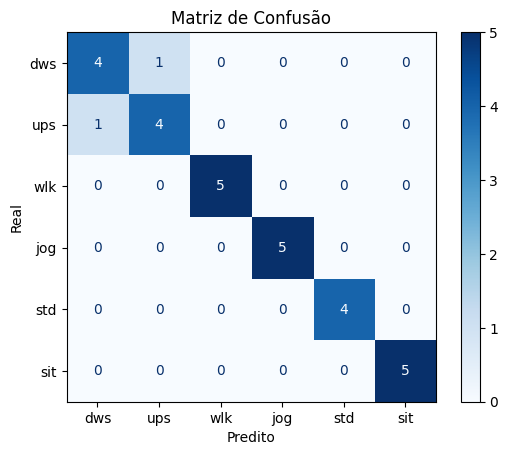

In [37]:
# gerando matriz de confusão
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
disp.plot(cmap=plt.cm.Blues,)
disp.ax_.set_title('Matriz de Confusão')
disp.ax_.set_xlabel('Predito')
disp.ax_.set_ylabel('Real')
plt.savefig('data/figures/gnn_minirocket_conf_mat.pdf', bbox_inches='tight')